In [1]:
import sys

#https://pypi.org/project/python-mnist/
new_path = 'python-mnist/mnist'
sys.path.append(new_path)

#https://pypi.org/project/python-mnist/
from mnist import MNIST
import numpy as np
from scipy.spatial.distance import cdist
import math

#https://pypi.org/project/python-mnist/
mndata = MNIST('./python-mnist/data')

images, labels = mndata.load_training()
n = len(images[0])
%matplotlib inline
import matplotlib.pyplot as plt

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)
m = int(np.sqrt(n))
C = np.arange(m)
C = cartesian_product(C, C)
C = cdist(C, C)
C = C / np.median(C)
C[C==0] = 1e-4
#(C / np.median(C)).max()

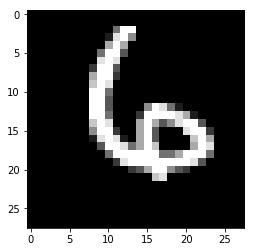

In [2]:
delta = 1e-6
l = len(images)

def random_mnist():
    p, q = np.random.randint(l), np.random.randint(l)
    p, q = np.float64(images[p]), np.float64(images[q])
    p[p < delta] = delta
    q[q < delta] = delta
    return p / sum(p), q / sum(q)

p, q = random_mnist()
plot = True
if plot:
    #plt.imshow(p.reshape(-1, m), cmap=plt.get_cmap('gray'))
    plt.imshow(q.reshape(-1, m), cmap=plt.get_cmap('gray'))

def mround(x):
    r = p / x.dot(one)
    r[r>1] = 1.
    F = np.diag(r).dot(x)
    c = q / (x.T).dot(one)
    c[c>1] = 1.
    F = F.dot(np.diag(c))
    err_r = p - F.dot(one)
    err_c = q - (F.T).dot(one)
    return F + np.outer(err_r, err_c) / abs(err_r).sum()

In [3]:
eps = 1e-2
gamma = eps/3/np.log(n)
one = np.ones(n, np.float64)
I = np.ones([n,n], np.float64)
def f_true(x):
    return (C * x).sum()

def f_(x):
    y = (x.reshape(-1)).copy()
    y[x.reshape(-1) == 0.] = 1.
    y = y.reshape(n, -1)
    return (C * x).sum() + gamma * (x * np.log(y)).sum()

def x_(la, mu):
    x_star = np.exp((-C - np.outer(la, one) - np.outer(one, mu)) / gamma - I)
    #x_star = np.exp(-C/gamma) * np.exp(-np.outer(la, one)/gamma) * np.exp(-np.outer(one, mu)/gamma) / np.e
    return x_star

def phi_(lamu):
    x_star = x_(lamu[:n], lamu[n:])
    return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * x_star.sum()
                    
def grad_phi_(lamu):
    x_star = x_(lamu[:n], lamu[n:])
    return np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)

def phi_grad_phi_(lamu):
    x_star = x_(lamu[:n], lamu[n:])
    return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * x_star.sum(), np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)

def phi_1d_(x, e):
    def f1d(h):
        return phi_(x + h * e)
    return f1d

def grad_phi_1d_(x, e):
    def gradf1d(h):
        return np.array(grad_phi_(x + h * e).dot(e))
    return gradf1d

def phi_grad_phi_1d_(x, e):
    def fgradf1d(h):
        lamu = x + h * e
        x_star = x_(lamu[:n], lamu[n:])
        return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * x_star.sum(), np.array(np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0).dot(e))
    return fgradf1d    



# 1802.04367

In [4]:
def APDAGD(wtime):
    L = 1.
    betta = alpha = 0.
    x_hat = np.zeros([n, n], np.float64)
    z = np.zeros(2*n, np.float64)
    z_new = np.zeros(2*n, np.float64)
    eta = np.zeros(2*n, np.float64)
    eta_new  = np.zeros(2*n, np.float64)
    k=0
    phi_etas = []
    phis = []
    xs = []
    times = []
    start_time = time.clock()
    while (time.clock() - start_time < wtime):
        L = L / 2
        while True:
            alpha_new = (1 + np.sqrt(4*L*betta + 1)) / 2 / L
            betta_new = betta + alpha_new
            tau = alpha_new / betta_new
            lamu_new = tau * z + (1 - tau) * eta
            
            #phi_new, grad_phi_new = phi_grad_phi_(lamu_new)
            x_star = x_(lamu_new[:n], lamu_new[n:])
            phi_new = lamu_new[:n].dot(p) + lamu_new[n:].dot(q) + gamma * x_star.sum()
            grad_phi_new = np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)
            
            z_new = z - alpha_new * grad_phi_new
            eta_new = tau * z_new + (1-tau) * eta
            phi_eta = phi_(eta_new)
            if phi_eta <= phi_new + grad_phi_new.dot(eta_new - lamu_new) + L * ((eta_new - lamu_new)**2).sum() / 2:
                alpha, betta = alpha_new, betta_new
                z = z_new.copy()
                eta = eta_new.copy()
                break    
            L = L * 2
            del lamu_new, grad_phi_new, phi_eta
        x_hat = tau * x_star + (1 - tau) * x_hat
        xs.append(x_hat)
        phis.append(phi_new)    
        del phi_new
        times.append(time.clock() - start_time)
        k=k+1
    return phis, xs, times, k

# 1809.05895 (by Sergey Guminov)

In [5]:
def GoldenSectionSearch(f, v_k, x_k, eps, *args):
    tau = (math.sqrt(5) + 1)/2
    a_k = 0
    b_k = 1
    Nmin = math.floor(math.log((b_k - a_k)/eps, tau)) + 1
    y_k = a_k + (b_k - a_k)/tau/tau
    z_k = a_k + (b_k - a_k)/tau
    Current = f(v_k + y_k*(x_k - v_k), *args)
    IsNextZ = 1
    beta = y_k
    k = 1
    while (k < Nmin):
        if (IsNextZ == 1):
            ComputeNew = f(v_k + z_k*(x_k - v_k), *args)
            if (Current <= ComputeNew):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                IsNextZ = 0
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                Current = ComputeNew
                beta = z_k
        elif (IsNextZ == 0):
            ComputeNew = f(v_k + y_k*(x_k - v_k), *args)
            if (ComputeNew <= Current):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                Current = ComputeNew
                beta = y_k
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                IsNextZ = 1
        k += 1 
    return beta

def BinSearch(start, MaxSteps, f, gradf, y_0, eps, *args):
    grad = gradf(y_0, *args)
    x0 = np.copy(start)
    f1 = f(y_0 - x0*grad, *args)
    IterNum = 0
    while (IterNum < MaxSteps):
        f2 = f(y_0 - 2*x0*grad, *args)
        if (f1 < f2):
            break
        else:
            f1 = f2
            x0 = 2*x0
        IterNum += 1
    tau = (math.sqrt(5) + 1)/2
    a_k = 0
    b_k = 2*x0
    Nmin = math.floor(math.log((b_k - a_k)/eps, tau)) + 1
    y_k = a_k + (b_k - a_k)/tau/tau
    z_k = a_k + (b_k - a_k)/tau
    Current = f(y_0 - y_k*grad, *args)
    IsNextZ = 1
    h = y_k
    k = 1
    while (k < Nmin):
        if (IsNextZ == 1):
            ComputeNew = f(y_0 - z_k*grad, *args)
            if (Current <= ComputeNew):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                IsNextZ = 0
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                Current = ComputeNew
                h = z_k
        elif (IsNextZ == 0):
            ComputeNew = f(y_0 - y_k*grad, *args)
            if (ComputeNew <= Current):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                Current = ComputeNew
                h = y_k
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                IsNextZ = 1
        k += 1 
    return h

def UAGM_Guminov(NumIter, x0, f, gradf, eps, eps_f, BinSearchStart, BinSearchMaxSteps, *args):
    k = 0
    v_k = copy.deepcopy(x0)
    x_k = copy.deepcopy(x0)
    A_k = 0
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    farr[0] = f(x_k, *args)
    fgradarr[0] = linalg.norm(gradf(x_k, *args))
    while (k < NumIter):
        beta = GoldenSectionSearch(f, v_k, x_k, eps, *args)
        y_k = v_k + beta*(x_k - v_k)
        h = BinSearch(BinSearchStart, BinSearchMaxSteps, f, gradf, y_k, eps, *args)
        grad_fy = gradf(y_k, *args)
        x_k = y_k - h*gradf(y_k, *args)
        f_xk = f(x_k, *args)
        const = (f(y_k, *args) - f_xk+eps_f/2)
        a_k = (const + (const**2 + 2*(const-eps_f/2)*A_k*(linalg.norm(grad_fy)**2))**0.5)/(linalg.norm(grad_fy)**2)
        A_k += a_k
        v_k -= a_k * grad_fy
        k += 1
        farr[k] = f_xk
        fgradarr[k] = linalg.norm(gradf(x_k, *args))
    return x_k, farr, fgradarr

def AGMsDR_Guminov(NumIter, x0, f, gradf, eps, BinSearchStart, BinSearchMaxSteps, *args):
    k = 0
    v_k = copy.deepcopy(x0)
    x_k = copy.deepcopy(x0)
    A_k = 0
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    farr[0] = f(x_k, *args)
    fgradarr[0] = linalg.norm(gradf(x_k, *args))
    while (k < NumIter):
        beta = GoldenSectionSearch(f, v_k, x_k, eps, *args)
        y_k = v_k + beta*(x_k - v_k)
        h = BinSearch(BinSearchStart, BinSearchMaxSteps, f, gradf, y_k, eps, *args)
        grad_fy = gradf(y_k, *args)
        x_k = y_k - h*gradf(y_k, *args)
        f_xk = f(x_k, *args)
        const = 2*(f(y_k, *args) - f_xk)/(linalg.norm(grad_fy)**2)
        a_k = (const + (const**2 + 4*const*A_k)**0.5)/2
        A_k += a_k
        v_k -= a_k * grad_fy
        k += 1
        farr[k] = f_xk
        fgradarr[k] = linalg.norm(gradf(x_k, *args))
    return x_k, farr, fgradarr

# 1809.05895 

In [6]:
def universal(f_, grad_f_, f_grad_f_, x, eps):
    L = 1.
    betta = alpha = 0.
    n = x.shape[0]
    while True:
        L = L / 2
        while True:
            f_x, grad_f_x = f_grad_f_(x)
            x_new = x - grad_f_x / L
            dx = x_new - x
            f_x_new = f_(x_new)
            if f_x_new <= f_x + grad_f_x.dot(dx) + L * dx.dot(dx) / 2:
                break    
            else:
                L = L * 2
        if(linalg.norm(grad_f_(x_new)) < eps):
            return x_new, f_x_new
        x = x_new.copy()
        
def binary(f_, grad_f_, h_0, max_steps, eps):
    f1 = f_(h_0)
    i = 0
    while (i < max_steps):
        f2 = f_(2*h_0)
        if (f1 < f2):
            break
        else:
            f1 = f2
            h_0 = 2*h_0
        i += 1
    tau = (math.sqrt(5) + 1)/2
    a_k = 0
    b_k = 2*h_0
    N_min = math.floor(math.log((b_k - a_k)/eps, tau)) + 1
    y_k = a_k + (b_k - a_k)/tau/tau
    z_k = a_k + (b_k - a_k)/tau
    current = f_(y_k)
    IsNextZ = 1
    h = y_k
    k = 1
    #while (k < N_min):
    while True:
        if (IsNextZ == 1):
            new = f_(z_k)
            if (current <= new):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                IsNextZ = 0
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                current = new
                h = z_k
        elif (IsNextZ == 0):
            new = f_(y_k)
            if (new <= current):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                current = new
                h = y_k
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                IsNextZ = 1
        if(linalg.norm(grad_f_(h)) < eps):
            break
        k += 1 
    return h

def AGMsDR(wtime, eps_search, design='u'):
    A = 0.
    x = np.zeros(2*n, np.float64)
    v = x.copy()
    psi_A = 0.5
    psi_b = x.copy()
    k=0
    h = 1e-5
    phis = []
    lamus = []
    times = []
    start_time = time.clock()
    while (time.clock() - start_time < wtime):
        beta = binary(phi_1d_(v, x - v), grad_phi_1d_(v, x - v), 5e-1, 4, eps_search)
        f_y = phi_1d_(v, x - v)(beta)
        #beta, f_y =  universal(phi_1d_(v, x-v), grad_phi_1d_(v, x-v), phi_grad_phi_1d_(v, x-v), np.zeros(1, np.float64), 0.000001)
        if False:
            xx = np.linspace(beta - 0.01*beta, beta + 0.01*beta, 10)
            yy = [(phi_1d_(v, x-v))(j) for j in xx]
            plt.plot(xx, yy)
            plt.show()
        y = v + beta * (x - v)
        grad_f_y = grad_phi_(y)
        norm_grad_f_y = np.linalg.norm(grad_f_y)
        grad_f_sharp = grad_f_y / norm_grad_f_y
        if design == 'u':
            h, f_x =  universal(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), phi_grad_phi_1d_(y, -grad_f_sharp), 0.*np.ones(1, np.float64), eps_search)
        else:
            h =  binary(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), 1e-1, 1000, eps_search)
            f_x = phi_1d_(y, -grad_f_sharp)(h)
        if False:
            xx = np.linspace(h - 0.01*h, h + 0.01*h, 10)
            yy = [(phi_1d_(y, -grad_f_sharp))(j) for j in xx]
            plt.plot(xx, yy)
            plt.show()
        x = y - h * grad_f_sharp
        g, a = (f_x - f_y), norm_grad_f_y**2
        alpha = (-g + np.sqrt(g*g - 2*a*g*A)) / a 
        A = A + alpha
        psi_b = psi_b + alpha * (grad_f_y)
        v = -psi_b / psi_A
        k = k + 1
        phis.append(f_x)
        lamus.append(x)
        times.append(time.clock() - start_time)
    return phis, lamus,  times, k


def UAGMsDR(wtime, eps_search, eps_f, design='u'):
    k = 0
    x = np.zeros(2*n, np.float64)
    v = copy.deepcopy(x)
    A = 0
    phis = []
    lamus = []
    times = []
    start_time = time.clock()
    while (time.clock() - start_time < wtime):
        beta = binary(phi_1d_(v, x - v), grad_phi_1d_(v, x - v), 5e-1, 4, eps_search)
        f_y = phi_1d_(v, x - v)(beta)
        y = v + beta*(x - v)
        
        grad_f_y = grad_phi_(y)
        norm_grad_f_y = np.linalg.norm(grad_f_y)
        grad_f_sharp = grad_f_y / norm_grad_f_y
        
        if design == 'u':
            h, f_x =  universal(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), phi_grad_phi_1d_(y, -grad_f_sharp), 0.*np.ones(1, np.float64), eps_search)
        else:
            h =  binary(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), 1e-1, 1000, eps_search)
            f_x = phi_1d_(y, -grad_f_sharp)(h)
        x = y - h*grad_f_sharp
        
        const = (f_y - f_x + eps_f/2)
        a = (const + (const**2 + 2*(const-eps_f/2)*A*(norm_grad_f_y**2))**0.5)/(norm_grad_f_y**2)
        A += a
        v -= a * grad_f_y
        k += 1
        phis.append(f_x)
        lamus.append(x)
        times.append(time.clock() - start_time)
    return phis, lamus,  times, k

# Q -  standard simplex

In [57]:
eps = 1e-2
gamma = eps/3/np.log(n)
one = np.ones(n, np.float64)
I = np.ones([n,n], np.float64)
def f_true(x):
    return (C * x).sum()

def f_simplex_(x):
    y = (x.reshape(-1)).copy()
    y[x.reshape(-1) == 0.] = 1.
    y = y.reshape(n, -1)
    return (C * x).sum() + gamma * (x * np.log(y)).sum()

def x_s_(la, mu):
    x_star = np.exp((-C - np.outer(la, one) - np.outer(one, mu)) / gamma - I)
    #x_star = np.exp(-C/gamma) * np.exp(-np.outer(la, one)/gamma) * np.exp(-np.outer(one, mu)/gamma) / np.e
    return x_star / x_star.sum()

def x_simplex_(la, mu):
    x_star = np.exp((-C - np.outer(la, one) - np.outer(one, mu)) / gamma - I)
    #x_star = np.exp(-C/gamma) * np.exp(-np.outer(la, one)/gamma) * np.exp(-np.outer(one, mu)/gamma) / np.e
    return x_star

def phi_simplex_(lamu):
    x_star = x_simplex_(lamu[:n], lamu[n:])
    s = x_star.sum()
    return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * (1 + np.log(s))
                    
def grad_phi_simplex_(lamu):
    x_star = x_simplex_(lamu[:n], lamu[n:])
    x_star = x_star / x_star.sum()
    return np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)

def phi_grad_phi_simplex_(lamu):
    x_star = x_simplex_(lamu[:n], lamu[n:])
    s = x_star.sum()
    x_star = x_star / s
    return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * (1 + np.log(s)), np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)

def phi_1d_simplex_(x, e):
    def f1d(h):
        return phi_simplex_(x + h * e)
    return f1d

def grad_phi_1d_simplex_(x, e):
    def gradf1d(h):
        return np.array(grad_phi_simplex_(x + h * e).dot(e))
    return gradf1d

def phi_grad_phi_1d_simplex_(x, e):
    def fgradf1d(h):
        lamu = x + h * e
        x_star = x_simplex_(lamu[:n], lamu[n:])
        s = x_star.sum()
        x_star = x_star / s
        return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * (1 + np.log(s)), np.array(np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0).dot(e))
    return fgradf1d    

In [35]:
def APDAGD_simplex(wtime):
    L = 1.
    betta = 0.
    alpha = 0.
    x_hat = 0.*np.ones([n, n], np.float64)
    z = np.zeros(2*n, np.float64)
    z_new = np.zeros(2*n, np.float64)
    eta = np.zeros(2*n, np.float64)
    eta_new  = np.zeros(2*n, np.float64)
    k=0
    phi_etas = []
    phis = []
    xs = []
    times = []
    start_time = time.clock()
    while (time.clock() - start_time < wtime):
        L = L / 2
        while True:
            alpha_new = (1 + np.sqrt(4*L*betta + 1)) / 2 / L
            betta_new = betta + alpha_new
            tau = alpha_new / betta_new
            lamu_new = tau * z + (1 - tau) * eta
                    
            x_star = x_simplex_(lamu_new[:n], lamu_new[n:])
            s = x_star.sum()
            phi_new = lamu_new[:n].dot(p) + lamu_new[n:].dot(q) + gamma * (1 + np.log(s))

            x_star = x_star / s
            grad_phi_new = np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)
            
            z_new = z - alpha_new * grad_phi_new
            eta_new = tau * z_new + (1-tau) * eta
            phi_eta = phi_simplex_(eta_new)
            if phi_eta <= phi_new + grad_phi_new.dot(eta_new - lamu_new) + L * ((eta_new - lamu_new)**2).sum() / 2:
                alpha, betta = alpha_new, betta_new
                z = z_new.copy()
                eta = eta_new.copy()
                break    
            L = L * 2
            del grad_phi_new
        x_hat = tau * x_star + (1 - tau) * x_hat
        xs.append(x_hat)
        phis.append(phi_new)    
        times.append(time.clock() - start_time)
        k=k+1
    return phis, xs, times, k

def AGMsDR_simplex(wtime, eps_search, design='u'):
    A = 0.
    x = np.zeros(2*n, np.float64)
    v = x.copy()
    psi_A = 0.5
    psi_b = x.copy()
    k=0
    h = 1e-5
    phis = []
    lamus = []
    times = []
    start_time = time.clock()
    while (time.clock() - start_time < wtime):
        beta = binary(phi_1d_simplex_(v, x - v), grad_phi_1d_simplex_(v, x - v), 5e-1, 4, eps_search)
        f_y = phi_1d_simplex_(v, x - v)(beta)
        #beta, f_y =  universal(phi_1d_simplex_(v, x-v), grad_phi_1d_simplex_(v, x-v), phi_grad_phi_1d_simplex_(v, x-v), np.zeros(1, np.float64), 0.000001)
        if False:
            xx = np.linspace(beta - 0.01*beta, beta + 0.01*beta, 10)
            yy = [(phi_1d_simplex_(v, x-v))(j) for j in xx]
            plt.plot(xx, yy)
            plt.show()
        y = v + beta * (x - v)
        grad_f_y = grad_phi_simplex_(y)
        norm_grad_f_y = np.linalg.norm(grad_f_y)
        grad_f_sharp = grad_f_y / norm_grad_f_y
        if design == 'u':
            h, f_x =  universal(phi_1d_simplex_(y, -grad_f_sharp), grad_phi_1d_simplex_(y, -grad_f_sharp), phi_grad_phi_1d_simplex_(y, -grad_f_sharp), 0.*np.ones(1, np.float64), eps_search)
        else:
            h =  binary(phi_1d_simplex_(y, -grad_f_sharp), grad_phi_1d_simplex_(y, -grad_f_sharp), 1e-1, 1000, eps_search)
            f_x = phi_1d_simplex_(y, -grad_f_sharp)(h)
        if False:
            xx = np.linspace(h - 0.01*h, h + 0.01*h, 10)
            yy = [(phi_1d_simplex_(y, -grad_f_sharp))(j) for j in xx]
            plt.plot(xx, yy)
            plt.show()
        x = y - h * grad_f_sharp
        g, a = (f_x - f_y), norm_grad_f_y**2
        alpha = (-g + np.sqrt(g*g - 2*a*g*A)) / a 
        A = A + alpha
        psi_b = psi_b + alpha * (grad_f_y)
        v = -psi_b / psi_A
        k = k + 1
        phis.append(f_x)
        lamus.append(x)
        times.append(time.clock() - start_time)
    return phis, lamus,  times, k

def UAGMsDR_simplex(wtime, eps_search, eps_f, design='u'):
    k = 0
    x = np.zeros(2*n, np.float64)
    v = copy.deepcopy(x)
    A = 0
    phis = []
    lamus = []
    times = []
    start_time = time.clock()
    while (time.clock() - start_time < wtime):
        beta = binary(phi_1d_simplex_(v, x - v), grad_phi_1d_simplex_(v, x - v), 5e-1, 4, eps_search)
        f_y = phi_1d_simplex_(v, x - v)(beta)
        y = v + beta*(x - v)
        
        grad_f_y = grad_phi_simplex_(y)
        norm_grad_f_y = np.linalg.norm(grad_f_y)
        grad_f_sharp = grad_f_y / norm_grad_f_y
        
        if design == 'u':
            h, f_x =  universal(phi_1d_simplex_(y, -grad_f_sharp), grad_phi_1d_simplex_(y, -grad_f_sharp), phi_grad_phi_1d_simplex_(y, -grad_f_sharp), 0.*np.ones(1, np.float64), eps_search)
        else:
            h =  binary(phi_1d_simplex_(y, -grad_f_sharp), grad_phi_1d_simplex_(y, -grad_f_sharp), 1e-1, 1000, eps_search)
            f_x = phi_1d_simplex_(y, -grad_f_sharp)(h)
        x = y - h*grad_f_sharp
        
        const = (f_y - f_x + eps_f/2)
        a = (const + (const**2 + 2*(const-eps_f/2)*A*(norm_grad_f_y**2))**0.5)/(norm_grad_f_y**2)
        A += a
        v -= a * grad_f_y
        k += 1
        phis.append(f_x)
        lamus.append(x)
        times.append(time.clock() - start_time)
    return phis, lamus,  times, k

# Comparison

In [8]:
import copy
from numpy import linalg
import time

In [33]:
p, q = random_mnist()

In [10]:
eps_search = 1e-2 #Line search accuracy
eps_f = eps   #function accuracy

# Line search: Universal vs Binary

In [21]:
wtime   = 60.   #Number of iterations
x0  = 0*np.ones(2*n, np.float64)     #Starting point
BinSearchStart = 0.0001
BinSearchMaxSteps = 50
args = []

phis2, lamus2, times2, _ = AGMsDR(wtime, eps_search, 'u')
phis3, lamus3, times3, _ = AGMsDR(wtime, eps_search, 'b')

#phis2, lamus2, times2, _ = UAGMsDR_simplex(wtime, eps_search, eps_f, 'u')
#phis3, lamus3, times3, _ = UAGMsDR_simplex(wtime, eps_search, eps_f, 'b')

[Text(0,0.5,u'dual objective'), Text(0.5,0,u'time')]

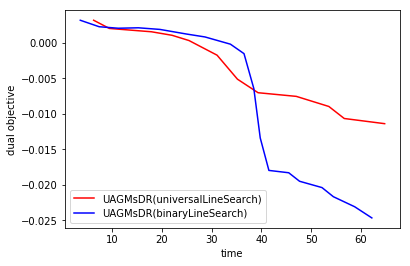

In [23]:
fig, ax = plt.subplots()
ax.plot(times2, phis2, '-r', label='UAGMsDR(universalLineSearch)')
ax.plot(times3, phis3, '-b', label='UAGMsDR(binaryLineSearch)')
leg = ax.legend();
ax.set(xlabel='time', ylabel='dual objective')

# UAGMsDR vs AGMsDR

In [15]:
N = 25

In [16]:
xans2, farr2, fgradarr2 = UAGM_Guminov(N, x0, phi_, grad_phi_, eps_search, eps_f, BinSearchStart, BinSearchMaxSteps, *args)

In [17]:
xans1, farr1, fgradarr1 = AGMsDR_Guminov(N, x0, phi_, grad_phi_, eps_search, BinSearchStart, BinSearchMaxSteps, *args)
xans2, farr2, fgradarr2 = UAGM_Guminov(N, x0, phi_, grad_phi_, eps_search, eps_f, BinSearchStart, BinSearchMaxSteps, *args)

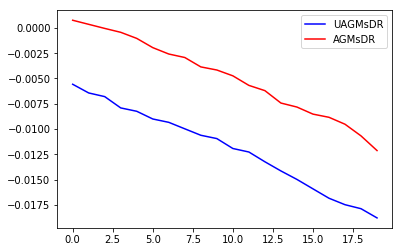

In [18]:
fig, ax = plt.subplots()
ax.plot(farr2[6:], '-b', label='UAGMsDR')
ax.plot(farr1[6:], '-r', label='AGMsDR')
leg = ax.legend();

# Simplex: APDAGD vs AGM vs UAGM


In [19]:
wtime = 150

In [37]:
phis5, lamus5, times5, N5 = AGMsDR_simplex(wtime, eps_search, design='b')

In [38]:
phis6, lamus6, times6, N6 = UAGMsDR_simplex(wtime, eps_search, eps_f, design='b')

In [36]:
phis7, xs7, times7, N7 = APDAGD_simplex(wtime)

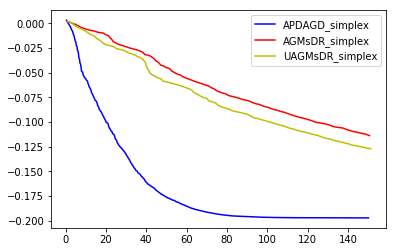

In [49]:
fig, ax = plt.subplots()
ax.plot(times7, phis7, '-b', label='APDAGD_simplex')
ax.plot(times5, phis5, '-r', label='AGMsDR_simplex')
ax.plot(times6, phis6, '-y', label='UAGMsDR_simplex')
leg = ax.legend();

# APDAGD: Simplex vs non-negative Orthant

In [40]:
phis1, xs1, times1, N1 = APDAGD(wtime)

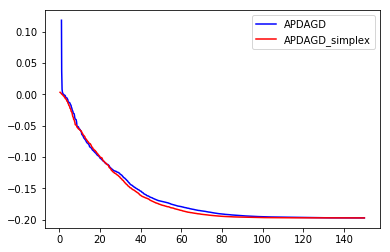

In [41]:
fig, ax = plt.subplots()
ax.plot(times1, phis1, '-b', label='APDAGD')
ax.plot(times7, phis7, '-r', label='APDAGD_simplex')
leg = ax.legend();

# Dual objectives vs Time

In [42]:
phis2, lamus2, times2, N2 = AGMsDR(wtime, eps_search)

In [45]:
phis3, lamus3, times3, N3 = UAGMsDR(wtime, eps_search, eps_f, design='u')

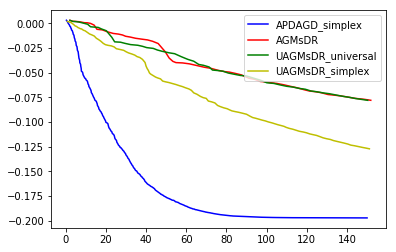

In [48]:
fig, ax = plt.subplots()
ax.plot(times7, phis7, '-b', label='APDAGD_simplex')
ax.plot(times2, phis2, '-r', label='AGMsDR')
ax.plot(times3, phis3, '-g', label='UAGMsDR_universal')
ax.plot(times6, phis6, '-y', label='UAGMsDR_simplex')
leg = ax.legend();

# Dual Objective vs Iterations

In [50]:
N = min(N1, N2, N3, N6)

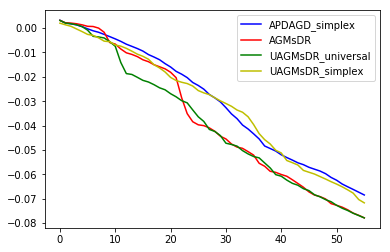

In [53]:
fig, ax = plt.subplots()
ax.plot(phis7[:N], '-b', label='APDAGD_simplex')
ax.plot(phis2[:N], '-r', label='AGMsDR')
ax.plot(phis3[:N], '-g', label='UAGMsDR_universal')
ax.plot(phis6[:N], '-y', label='UAGMsDR_simplex')
leg = ax.legend();

# Regularized Primal vs Iterations

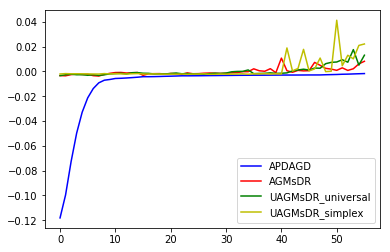

In [58]:
xs2 = [x_(i[:n], i[n:]) for i in lamus2[:N]]
xs3 = [x_(i[:n], i[n:]) for i in lamus3[:N]]
xs6 = [x_s_(i[:n], i[n:]) for i in lamus6[:N]]

f1 = [f_(i) for i in xs1[:N]]
f2 = [f_(i) for i in xs2]
f3 = [f_(i) for i in xs3]
f6 = [f_simplex_(i) for i in xs6]
fig, ax = plt.subplots()
ax.plot(f1, '-b', label='APDAGD')
ax.plot(f2, '-r', label='AGMsDR')
ax.plot(f3, '-g', label='UAGMsDR_universal')
ax.plot(f6, '-y', label='UAGMsDR_simplex')
leg = ax.legend();

# Non-regularized Primal vs Iterations

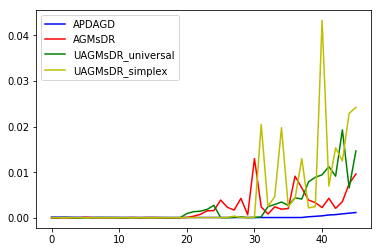

In [67]:
f1 = [f_true(i) for i in xs1[:N]]
f2 = [f_true(i) for i in xs2]
f3 = [f_true(i) for i in xs3]
f6 = [f_true(i) for i in xs6]
fig, ax = plt.subplots()
ax.plot(f1[10:], '-b', label='APDAGD')
ax.plot(f2[10:], '-r', label='AGMsDR')
ax.plot(f3[10:], '-g', label='UAGMsDR_universal')
ax.plot(f6[10:], '-y', label='UAGMsDR_simplex')
leg = ax.legend();

# Constraints residual vs Iterations

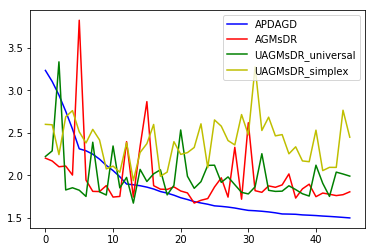

In [68]:
r1 = [np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs1[:N]]
r2 = [np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs2]
r3 = [np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs3]
r6 = [np.linalg.norm(i.dot(one) - p, 1) + np.linalg.norm(i.T.dot(one) - q, 1) for i in xs6]
fig, ax = plt.subplots()
ax.plot(r1[10:], '-b', label='APDAGD')
ax.plot(r2[10:], '-r', label='AGMsDR')
ax.plot(r3[10:], '-g', label='UAGMsDR_universal')
ax.plot(r6[10:], '-y', label='UAGMsDR_simplex')
leg = ax.legend();

# Non-regularized Primal vs Iteration with Rounding

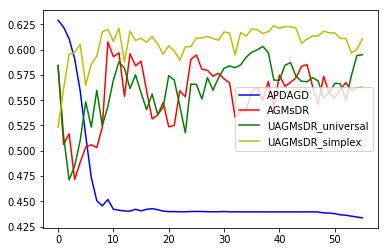

In [70]:
f1 = [f_true(mround(i)) for i in xs1[:N]]
f2 = [f_true(mround(i)) for i in xs2]
f3 = [f_true(mround(i)) for i in xs3]
f6 = [f_true(mround(i)) for i in xs6]
fig, ax = plt.subplots()
ax.plot(f1, '-b', label='APDAGD')
ax.plot(f2, '-r', label='AGMsDR')
ax.plot(f3, '-g', label='UAGMsDR_universal')
ax.plot(f6, '-y', label='UAGMsDR_simplex')
leg = ax.legend();